In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters

<function pandas.plotting._misc.register() -> 'None'>

In [2]:
# Set the style for our plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

In [3]:
file_url = "https://raw.githubusercontent.com/Ahmedtarrek4/Sales-dataset-/main/stores_sales_forecasting%20(1).csv"
df = pd.read_csv(file_url, encoding="ISO-8859-1")
df.replace([np.inf, -np.inf], np.nan, inplace=True)
print(df.head())

   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
1       2  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
2       4  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   
3       6  CA-2014-115812    6/9/2014   6/14/2014  Standard Class    BH-11710   
4      11  CA-2014-115812    6/9/2014   6/14/2014  Standard Class    BH-11710   

     Customer Name   Segment        Country             City  ... Postal Code  \
0      Claire Gute  Consumer  United States        Henderson  ...       42420   
1      Claire Gute  Consumer  United States        Henderson  ...       42420   
2   Sean O'Donnell  Consumer  United States  Fort Lauderdale  ...       33311   
3  Brosina Hoffman  Consumer  United States      Los Angeles  ...       90032   
4  Brosina Hoffman  Consumer  United States      Los Angeles  ...       90032   

   Region       Product ID

In [4]:
# 2. Data exploration
print("Dataset information:")
print(f"Shape of data: {df.shape}")

Dataset information:
Shape of data: (2121, 21)


In [5]:
# Get detailed information about the dataset
print("\nDetailed information about the dataset:")
print(df.info())


Detailed information about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2121 entries, 0 to 2120
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         2121 non-null   int64  
 1   Order ID       2121 non-null   object 
 2   Order Date     2121 non-null   object 
 3   Ship Date      2121 non-null   object 
 4   Ship Mode      2121 non-null   object 
 5   Customer ID    2121 non-null   object 
 6   Customer Name  2121 non-null   object 
 7   Segment        2121 non-null   object 
 8   Country        2121 non-null   object 
 9   City           2121 non-null   object 
 10  State          2121 non-null   object 
 11  Postal Code    2121 non-null   int64  
 12  Region         2121 non-null   object 
 13  Product ID     2121 non-null   object 
 14  Category       2121 non-null   object 
 15  Sub-Category   2121 non-null   object 
 16  Product Name   2121 non-null   object 
 17  Sales      

In [6]:
# Check for duplicates
print(df.duplicated().sum())
# Summarize basic statistics
print(df.describe())

0
            Row ID   Postal Code        Sales     Quantity     Discount  \
count  2121.000000   2121.000000  2121.000000  2121.000000  2121.000000   
mean   5041.643564  55726.556341   349.834887     3.785007     0.173923   
std    2885.740258  32261.888225   503.179145     2.251620     0.181547   
min       1.000000   1040.000000     1.892000     1.000000     0.000000   
25%    2568.000000  22801.000000    47.040000     2.000000     0.000000   
50%    5145.000000  60505.000000   182.220000     3.000000     0.200000   
75%    7534.000000  90032.000000   435.168000     5.000000     0.300000   
max    9991.000000  99301.000000  4416.174000    14.000000     0.700000   

            Profit  
count  2121.000000  
mean      8.699327  
std     136.049246  
min   -1862.312400  
25%     -12.849000  
50%       7.774800  
75%      33.726600  
max    1013.127000  


In [7]:
duplicate_rows = df[df.duplicated()]
duplicate_rows.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit


In [8]:
df = df.drop_duplicates()
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
3,6,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
4,11,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


In [9]:
# Check for missing values
print(df.isnull().sum())

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64


In [10]:
#We can see that there are no null values present in the dataset.
# Let's check the number of unique values in each column.
unique_counts = {}
for i in list(df.columns):
    unique_counts[i] = df[i].value_counts().shape[0]

pd.DataFrame(unique_counts, index=["unique count"]).transpose()

,unique count
Row ID,2121
Order ID,1764
Order Date,889
Ship Date,960
Ship Mode,4
Customer ID,707
Customer Name,707
Segment,3
Country,1
City,371


In [11]:

# Examine and clean column names
print("\nCleaned column names:")
df.columns = df.columns.str.strip()
print(df.columns)


Cleaned column names:
Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')


In [12]:
df = df.drop(columns=['Row ID'], errors='ignore')
print(df.head(3))

         Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
1  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
2  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   

    Customer Name   Segment        Country             City     State  \
0     Claire Gute  Consumer  United States        Henderson  Kentucky   
1     Claire Gute  Consumer  United States        Henderson  Kentucky   
2  Sean O'Donnell  Consumer  United States  Fort Lauderdale   Florida   

   Postal Code Region       Product ID   Category Sub-Category  \
0        42420  South  FUR-BO-10001798  Furniture    Bookcases   
1        42420  South  FUR-CH-10000454  Furniture       Chairs   
2        33311  South  FUR-TA-10000577  Furniture       Tables   

                                        Product Name     Sales  Quantity  \
0                  Bush Somerset Collection Bookcase  261.9600         2 

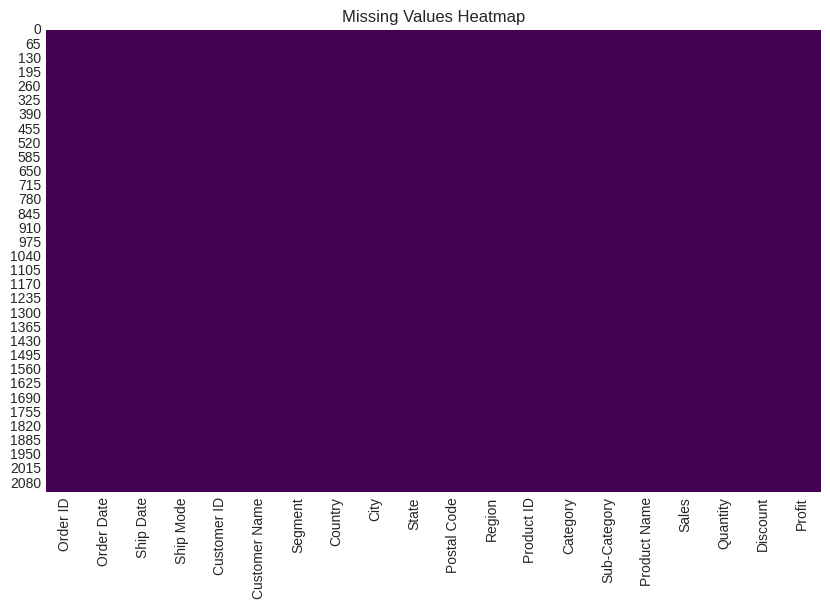

In [13]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

In [14]:
#checking duplicate values
df.nunique()

,0
Order ID,1764
Order Date,889
Ship Date,960
Ship Mode,4
Customer ID,707
Customer Name,707
Segment,3
Country,1
City,371
State,48


In [15]:
# 3. Preprocessing and Feature Engineering
# Handle missing values based on their nature
# For columns with small percentage of missing values, we can impute them
# For numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_cols:
    if df[col].isnull().sum() > 0:
        # Fill with median for numerical columns
        median_value = df[col].median()
        print(f"Filling missing values in {col} with median: {median_value}")
        df[col].fillna(median_value, inplace=True)

In [16]:
# For categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        # Fill with mode for categorical columns
        mode_value = df[col].mode()[0]
        print(f"Filling missing values in {col} with mode: {mode_value}")
        df[col].fillna(mode_value, inplace=True)

# Verify missing values are handled
print("\nMissing values after handling:")
print(df.isnull().sum())


Missing values after handling:
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64


In [17]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

In [18]:
# Check the time span of the data
print("\nEarliest order date:", df['Order Date'].min())
print("Latest order date:", df['Order Date'].max())
print("Date range span:", df['Order Date'].max() - df['Order Date'].min())


Earliest order date: 2014-01-06 00:00:00
Latest order date: 2017-12-30 00:00:00
Date range span: 1454 days 00:00:00


In [19]:
# Identify the sales column
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_cols:
    if any(term in col.lower() for term in ['sale', 'revenue', 'amount']):
        sales_column = col
        break
else:
    sales_column = 'Sales' if 'Sales' in df.columns else numeric_cols[0]

print(f"Using '{sales_column}' as the target column for forecasting")

Using 'Sales' as the target column for forecasting


In [20]:
df['Order Date'] = pd.to_datetime(df['Order Date'])  # تحويل العمود لتاريخ
monthly_sales = df.resample('M', on='Order Date')['Sales'].sum().to_frame()

In [21]:
# 3. Check for and handle missing values
monthly_sales.fillna(monthly_sales.rolling(window=3, min_periods=1).mean(), inplace=True)

In [22]:
# 4. Apply log transformation to stabilize variance
# Check if the data has zeros or negative values
min_value = monthly_sales[sales_column].min()
if min_value <= 0:
    # Add a constant to make all values positive
    offset = abs(min_value) + 1
    monthly_sales['log_sales'] = np.log(monthly_sales[sales_column] + offset)
else:
    monthly_sales['log_sales'] = np.log(monthly_sales[sales_column])

In [23]:
def handle_outliers(df):
    num_cols = df.select_dtypes(include=[np.number]).columns
    for col in num_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df
df = handle_outliers(df)

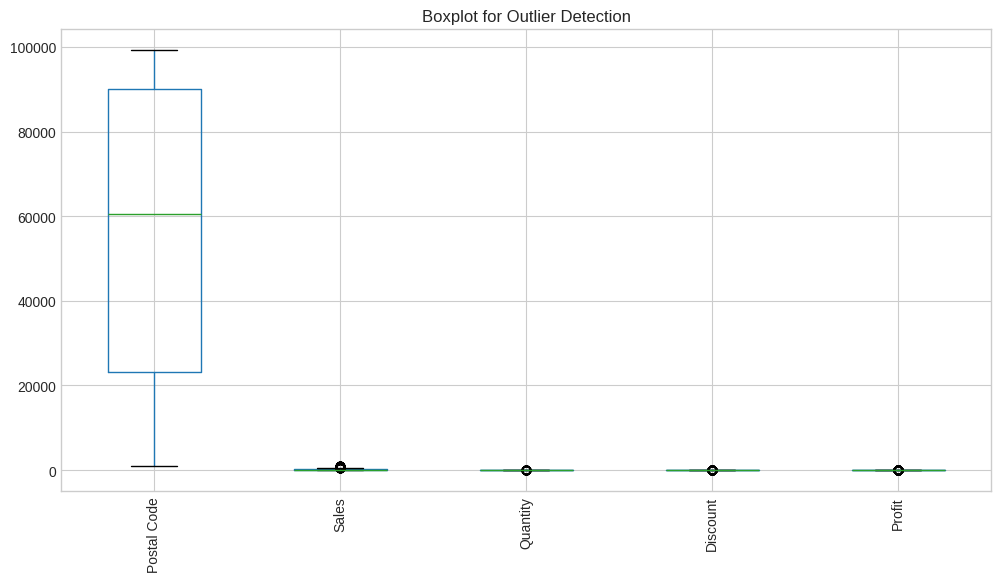

In [24]:
plt.figure(figsize=(12, 6))
df.boxplot(rot=90)
plt.title("Boxplot for Outlier Detection")
plt.show()

In [25]:
print("number of rows before removing outliers:", df.shape[0])
df = handle_outliers(df)
print("number of rows after removing outliers:", df.shape[0])

number of rows before removing outliers: 1597
number of rows after removing outliers: 1193


In [26]:
# 3. Data preparation
# Convert date columns to datetime format
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])
df['Order Month'] = df['Order Date'].dt.month
df['Order Year'] = df['Order Date'].dt.year
df['Profit Margin'] = df['Profit'] / df['Sales']
print("\nData types after date conversion:")
print(df.dtypes)


Data types after date conversion:
Order ID                 object
Order Date       datetime64[ns]
Ship Date        datetime64[ns]
Ship Mode                object
Customer ID              object
Customer Name            object
Segment                  object
Country                  object
City                     object
State                    object
Postal Code               int64
Region                   object
Product ID               object
Category                 object
Sub-Category             object
Product Name             object
Sales                   float64
Quantity                  int64
Discount                float64
Profit                  float64
Order Month               int32
Order Year                int32
Profit Margin           float64
dtype: object


In [27]:
# 4. Prepare  for time series analysis
# Identify potential sales/quantity columns
print("\nPotential numeric columns for forecasting:")
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
print(numeric_cols)


Potential numeric columns for forecasting:
Index(['Postal Code', 'Sales', 'Quantity', 'Discount', 'Profit',
       'Profit Margin'],
      dtype='object')


In [28]:
# Assuming 'Sales' is the column we want to forecast
# If 'Sales' is not the column name, replace it with the correct column
if 'Sales' in df.columns:
    sales_column = 'Sales'
elif 'Revenue' in df.columns:
    sales_column = 'Revenue'
elif 'Quantity' in df.columns:
    sales_column = 'Quantity'
else:
    # Try to identify a sales-related column
    for col in numeric_cols:
        if any(term in col.lower() for term in ['sale', 'revenue', 'amount', 'price', 'quantity']):
            sales_column = col
            break
    else:
        # If no suitable column found, use the first numeric column
        sales_column = numeric_cols[0]

print(f"\nUsing '{sales_column}' as the target column for forecasting")


Using 'Sales' as the target column for forecasting


In [29]:
# Aggregate data by date
print("\nAggregating data by date...")
daily_sales = df.groupby('Order Date')[sales_column].sum().reset_index()
daily_sales.set_index('Order Date', inplace=True)
print("\nDaily aggregated sales:")
print(daily_sales.head())


Aggregating data by date...

Daily aggregated sales:
              Sales
Order Date         
2014-01-10   51.940
2014-01-11    9.940
2014-01-13  333.999
2014-01-16  127.104
2014-01-20  345.570


In [30]:
# Check for missing dates in the time series
date_range = pd.date_range(start=daily_sales.index.min(), end=daily_sales.index.max(), freq='D')
print(f"\nTotal days in date range: {len(date_range)}")
print(f"Days with sales data: {len(daily_sales)}")
print(f"Missing days: {len(date_range) - len(daily_sales)}")



Total days in date range: 1451
Days with sales data: 677
Missing days: 774


In [31]:
# Reindex to include all dates and fill missing values
daily_sales = daily_sales.reindex(date_range, fill_value=0)
print("\nDaily sales after reindexing (including all dates):")
print(daily_sales.head())


Daily sales after reindexing (including all dates):
              Sales
2014-01-10   51.940
2014-01-11    9.940
2014-01-12    0.000
2014-01-13  333.999
2014-01-14    0.000


In [32]:
# Resample to different time frequencies for analysis
print("\nAggregating to different time frequencies...")
weekly_sales = daily_sales.resample('W').sum()
monthly_sales = daily_sales.resample('M').sum()
quarterly_sales = daily_sales.resample('Q').sum()

print("Weekly sales:")
print(weekly_sales.head())
print("\nMonthly sales:")
print(monthly_sales.head())
print("\nQuarterly sales:")
print(quarterly_sales.head())


Aggregating to different time frequencies...
Weekly sales:
              Sales
2014-01-12   61.880
2014-01-19  461.103
2014-01-26  588.018
2014-02-02  623.666
2014-02-09   14.560

Monthly sales:
               Sales
2014-01-31  1734.667
2014-02-28   558.278
2014-03-31  2754.722
2014-04-30  2063.169
2014-05-31  2415.037

Quarterly sales:
                Sales
2014-03-31  5047.6670
2014-06-30  6016.6256
2014-09-30  9046.3530
2014-12-31  9898.3362
2015-03-31  2624.0020


In [33]:
# Choose the appropriate time frequency for further analysis
# For retail, monthly is often a good balance
time_series_data = monthly_sales
print("\nSelected time frequency for analysis: Monthly")
print(time_series_data.head())


Selected time frequency for analysis: Monthly
               Sales
2014-01-31  1734.667
2014-02-28   558.278
2014-03-31  2754.722
2014-04-30  2063.169
2014-05-31  2415.037


In [34]:
monthly_sales['log_sales'] = np.log(monthly_sales['Sales'])

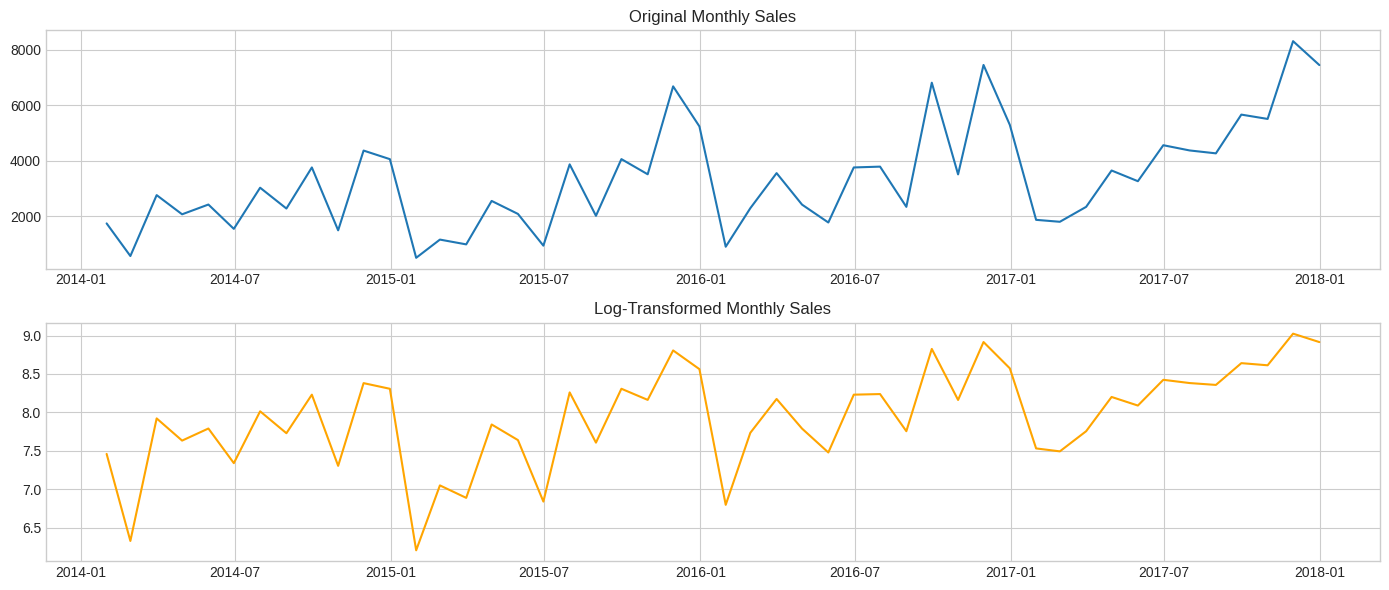

In [35]:
# 5. Time Series Visualization
plt.figure(figsize=(14, 6))
plt.subplot(211)
plt.plot(monthly_sales[sales_column], label='Original')
plt.title('Original Monthly Sales')
plt.grid(True)

plt.subplot(212)
plt.plot(monthly_sales['log_sales'], color='orange', label='Log-transformed')
plt.title('Log-Transformed Monthly Sales')
plt.grid(True)
plt.tight_layout()

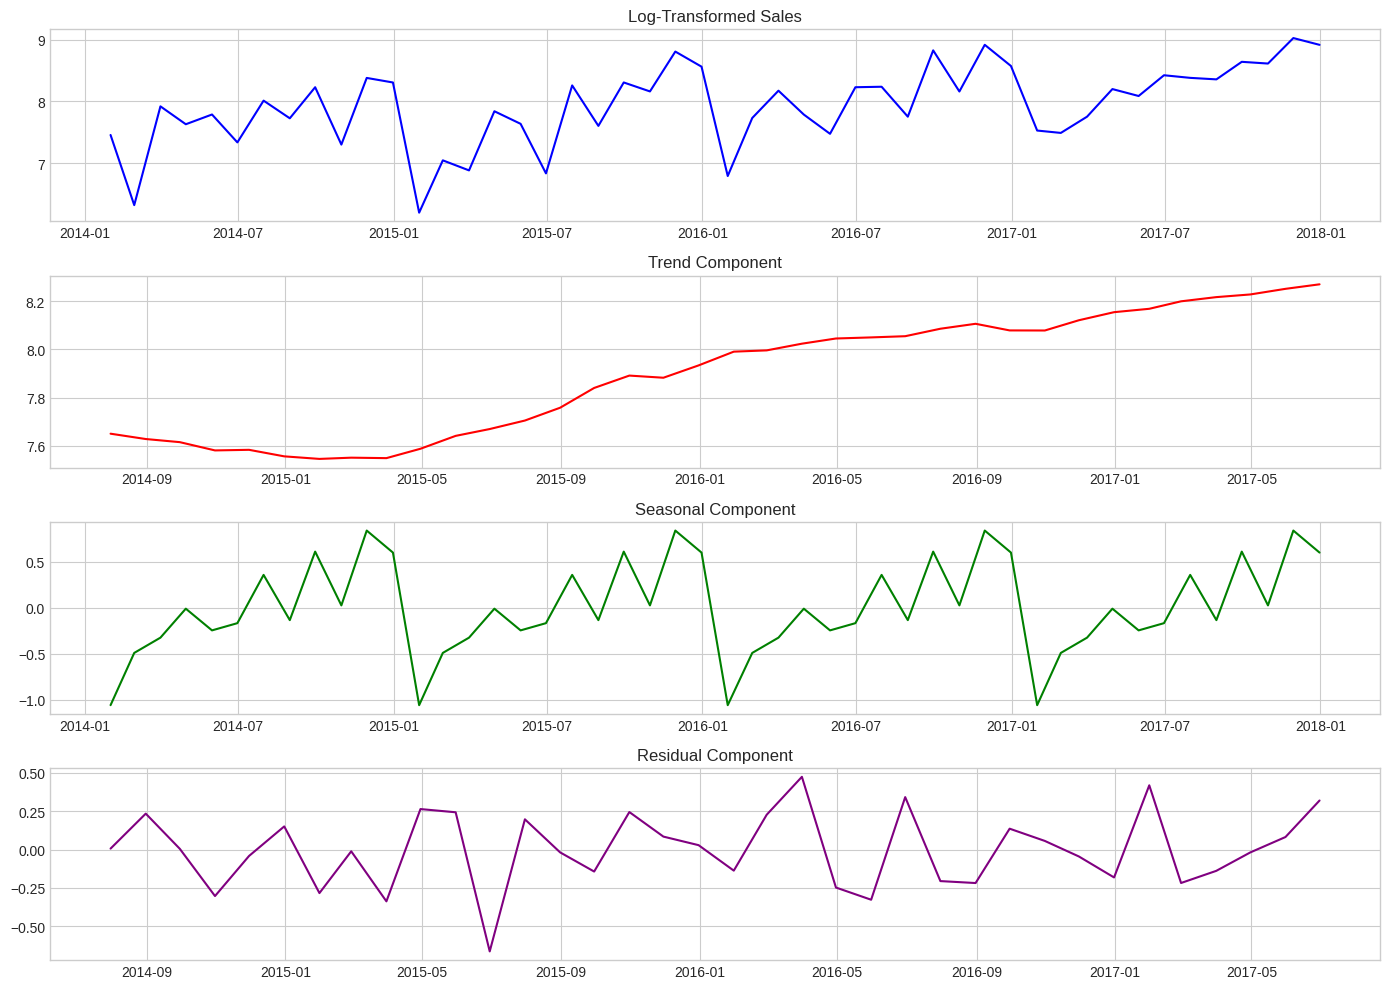

In [36]:
# 6. Decompose the time series to analyze components
decomposition = seasonal_decompose(monthly_sales['log_sales'], model='additive', period=12)

fig = plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(monthly_sales['log_sales'], color='blue')
plt.title('Log-Transformed Sales')
plt.grid(True)

plt.subplot(412)
plt.plot(decomposition.trend, color='red')
plt.title('Trend Component')
plt.grid(True)

plt.subplot(413)
plt.plot(decomposition.seasonal, color='green')
plt.title('Seasonal Component')
plt.grid(True)

plt.subplot(414)
plt.plot(decomposition.resid, color='purple')
plt.title('Residual Component')
plt.grid(True)
plt.tight_layout()

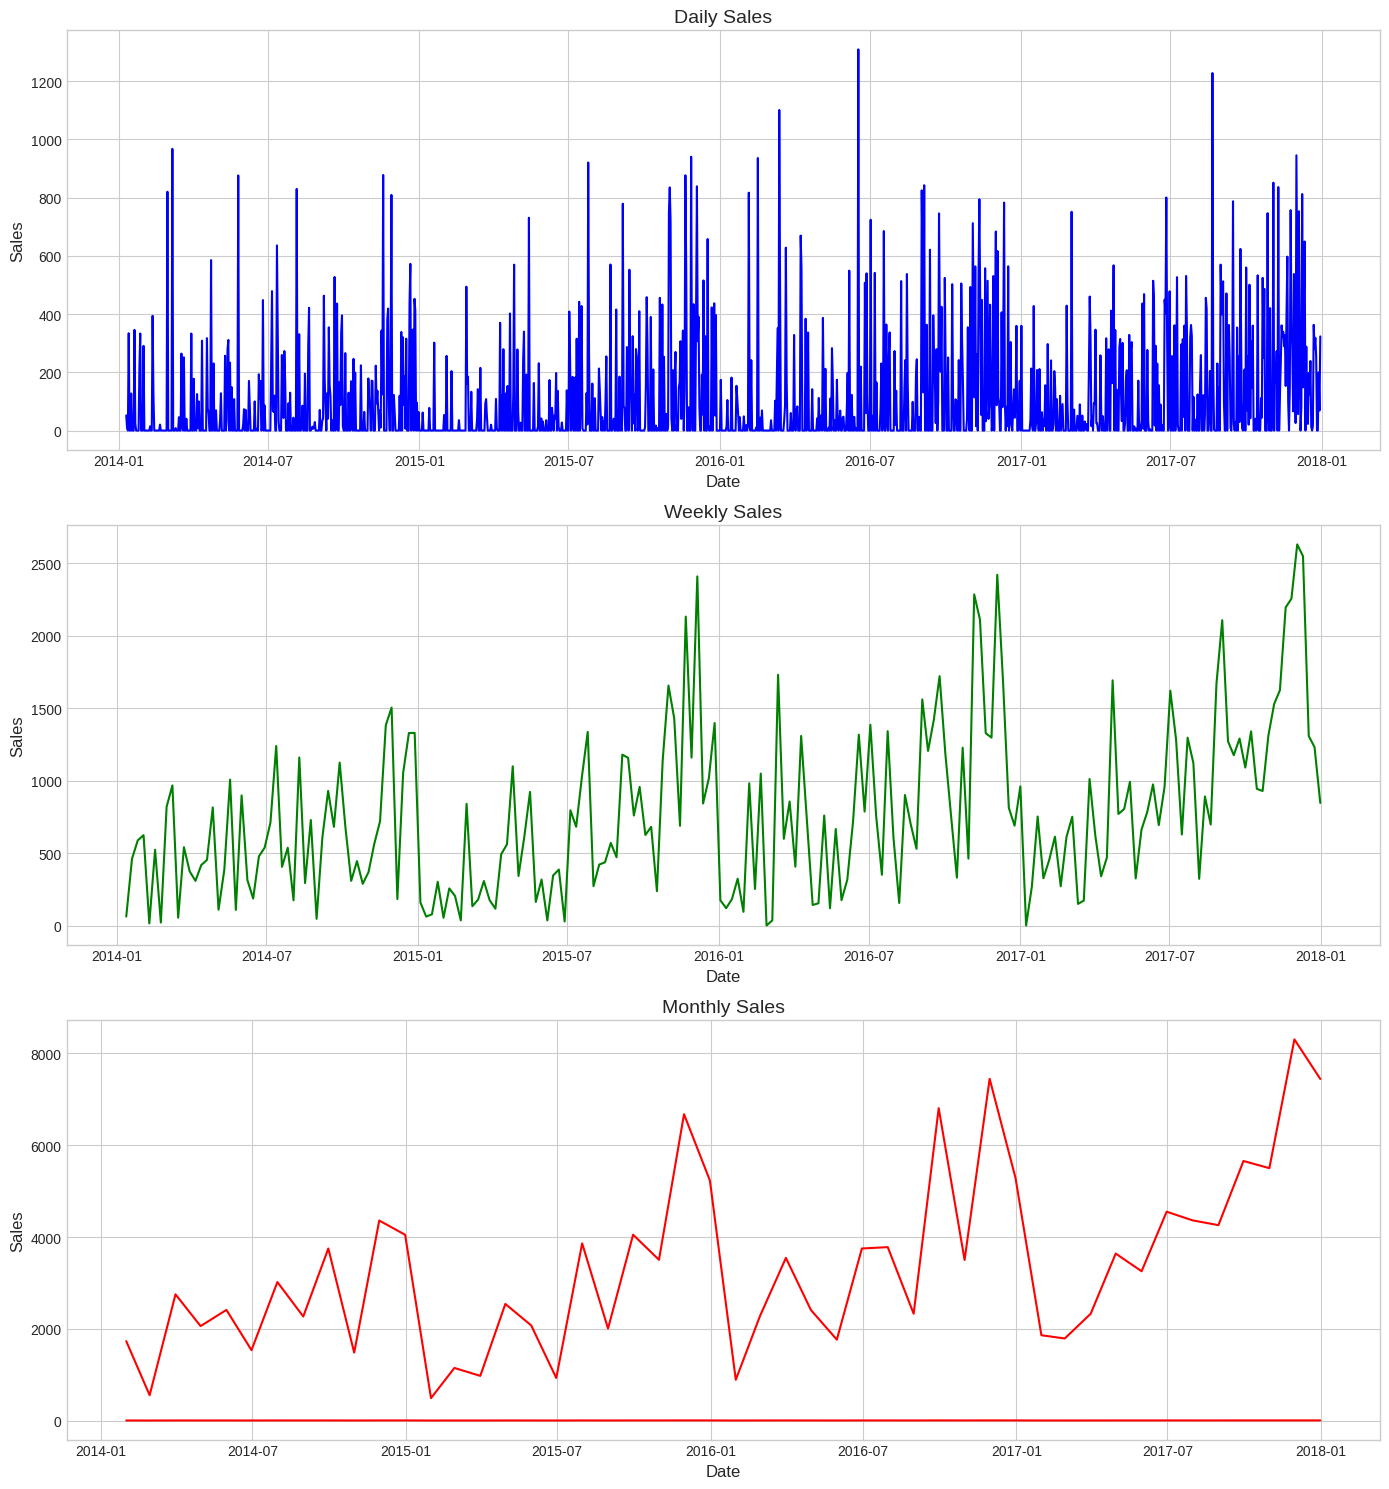

In [37]:
# alization the different time frequencies
fig, axs = plt.subplots(3, 1, figsize=(14, 15))

# Plot daily data
axs[0].plot(daily_sales, color='blue')
axs[0].set_title('Daily Sales', fontsize=14)
axs[0].set_xlabel('Date', fontsize=12)
axs[0].set_ylabel(f'{sales_column}', fontsize=12)
axs[0].grid(True)

# Plot weekly data
axs[1].plot(weekly_sales, color='green')
axs[1].set_title('Weekly Sales', fontsize=14)
axs[1].set_xlabel('Date', fontsize=12)
axs[1].set_ylabel(f'{sales_column}', fontsize=12)
axs[1].grid(True)

# Plot monthly data
axs[2].plot(monthly_sales, color='red')
axs[2].set_title('Monthly Sales', fontsize=14)
axs[2].set_xlabel('Date', fontsize=12)
axs[2].set_ylabel(f'{sales_column}', fontsize=12)
axs[2].grid(True)

plt.tight_layout()
plt.show()


Performing time series decomposition...


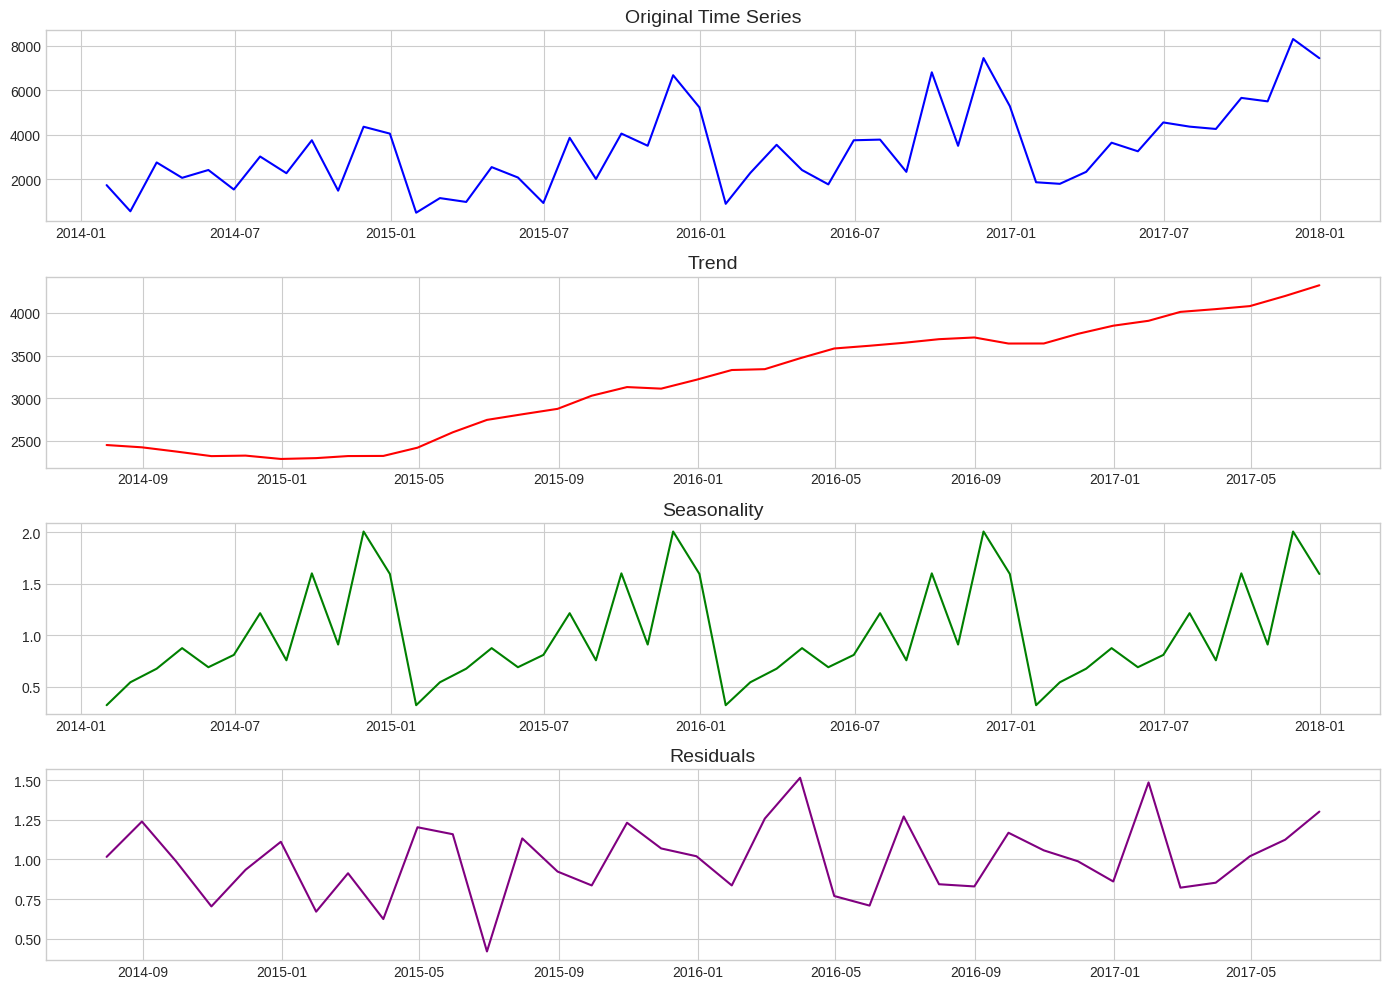

In [38]:
# 6. Check for the trend, seasonality, and residuals using decomposition
# For decomposition, we need enough data points and no missing values
# Ensure the time series has enough data points
time_series_data = monthly_sales['Sales']  # أو monthly_sales['log_sales']

if len(time_series_data) >= 24:
    print("\nPerforming time series decomposition...")

    if (time_series_data <= 0).any():
        print("Series contains zeros or negative values. Using additive decomposition.")
        decomposition = seasonal_decompose(time_series_data, model='additive', period=12)
    else:
        decomposition = seasonal_decompose(time_series_data, model='multiplicative', period=12)

    fig = plt.figure(figsize=(14, 10))
    ax1 = fig.add_subplot(411)
    plt.plot(time_series_data, color='blue')
    plt.title('Original Time Series', fontsize=14)
    plt.grid(True)

    ax2 = fig.add_subplot(412)
    plt.plot(decomposition.trend, color='red')
    plt.title('Trend', fontsize=14)
    plt.grid(True)

    ax3 = fig.add_subplot(413)
    plt.plot(decomposition.seasonal, color='green')
    plt.title('Seasonality', fontsize=14)
    plt.grid(True)

    ax4 = fig.add_subplot(414)
    plt.plot(decomposition.resid, color='purple')
    plt.title('Residuals', fontsize=14)
    plt.grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("\nNot enough data points for seasonal decomposition. Need at least 24 months of data.")
    print(f"Current data span: {len(time_series_data)} months")


In [39]:
print("number of rows before removing outliers:", df.shape[0])
df = handle_outliers(df)
print("number of rows after removing outliers:", df.shape[0])

number of rows before removing outliers: 1193
number of rows after removing outliers: 1072


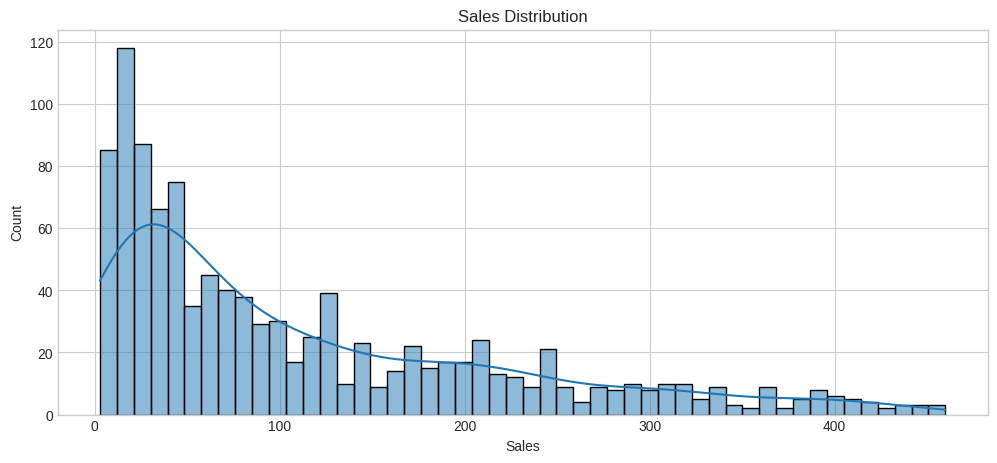

In [40]:
# 4. Exploratory Data Analysis (EDA)
## sales distribution
plt.figure(figsize=(12, 5))
sns.histplot(df['Sales'], bins=50, kde=True)
plt.title("Sales Distribution")
plt.show()

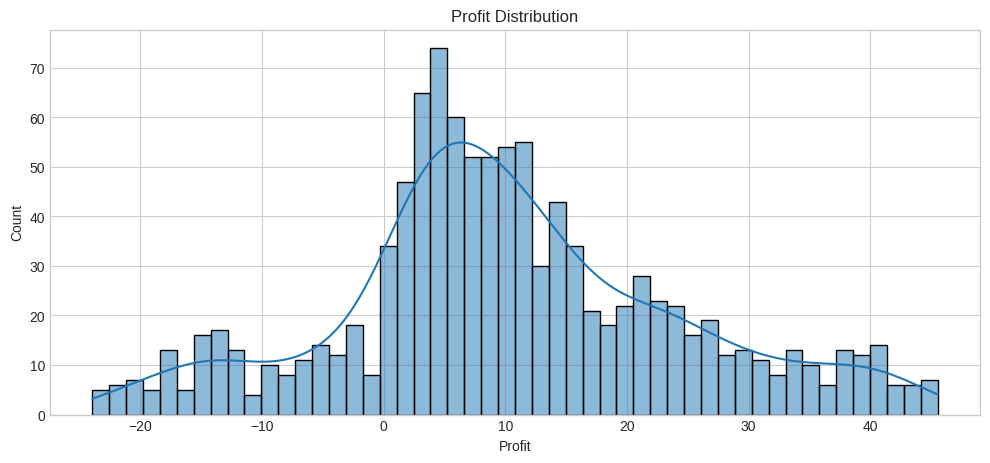

In [41]:
## profit distribution
plt.figure(figsize=(12, 5))
sns.histplot(df['Profit'], bins=50, kde=True)
plt.title("Profit Distribution")
plt.show()

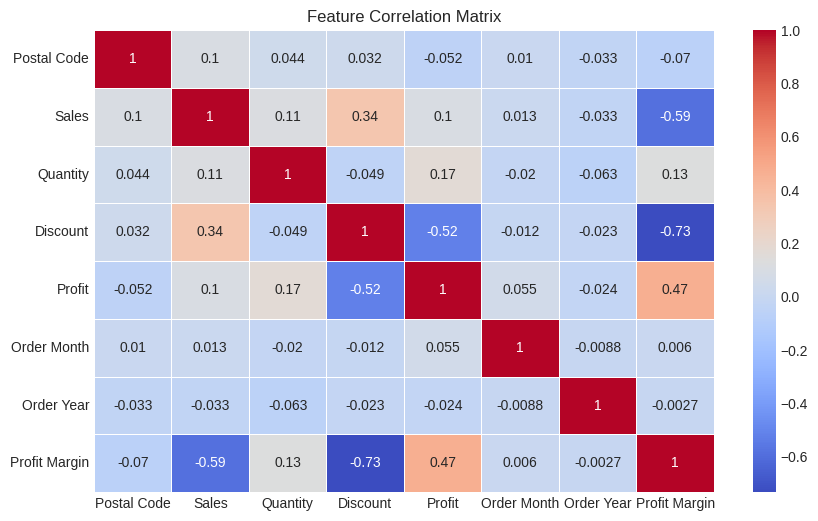

In [42]:
# Correlation Matrix

numeric_df = df.select_dtypes(include=[np.number])

plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

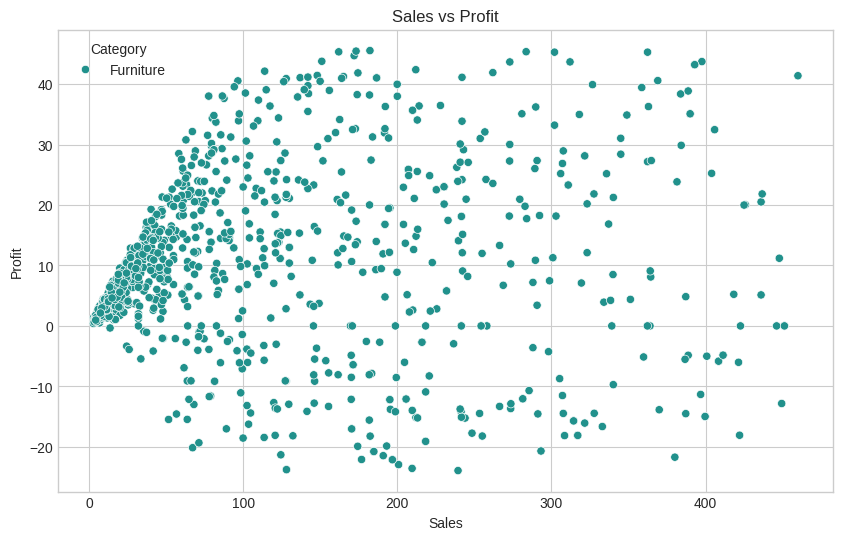

In [43]:
# Bivariate Analysis
# Sales vs Profit
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Sales', y='Profit', data=df, hue='Category', palette='viridis')
plt.title("Sales vs Profit")
plt.show()

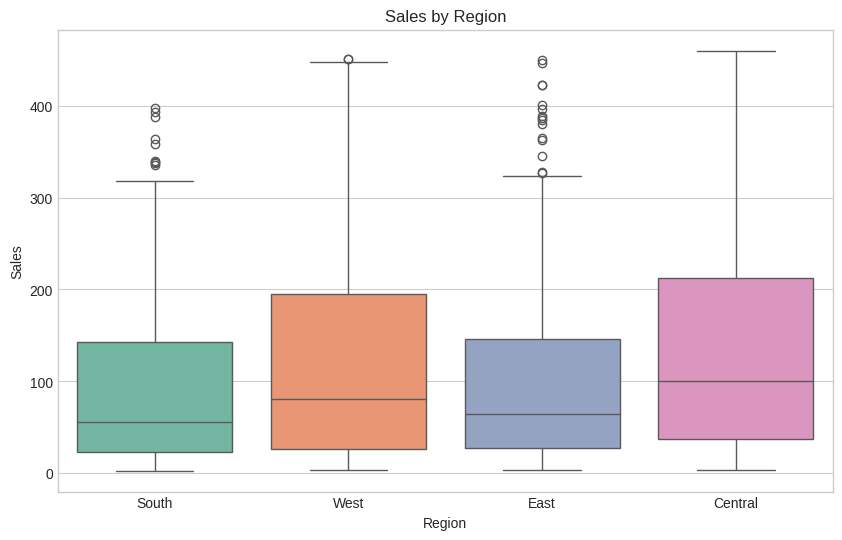

In [44]:
# Sales by Region
plt.figure(figsize=(10, 6))
sns.boxplot(x='Region', y='Sales', data=df, palette='Set2')
plt.title("Sales by Region")
plt.show()

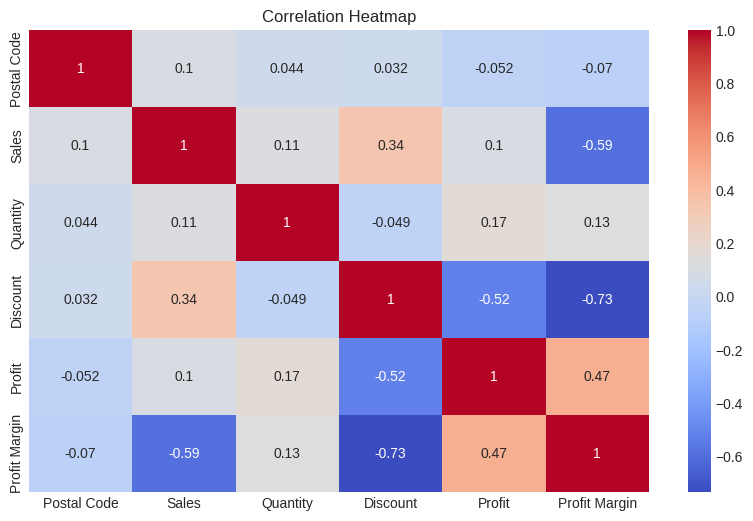

Numerical columns being used: ['Postal Code', 'Sales', 'Quantity', 'Discount', 'Profit', 'Profit Margin']


In [45]:
# Multivariate Analysis
# First, let's identify the correct numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Create Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# If you want to see what columns are actually being used, you can print them:
print("Numerical columns being used:", list(numerical_cols))

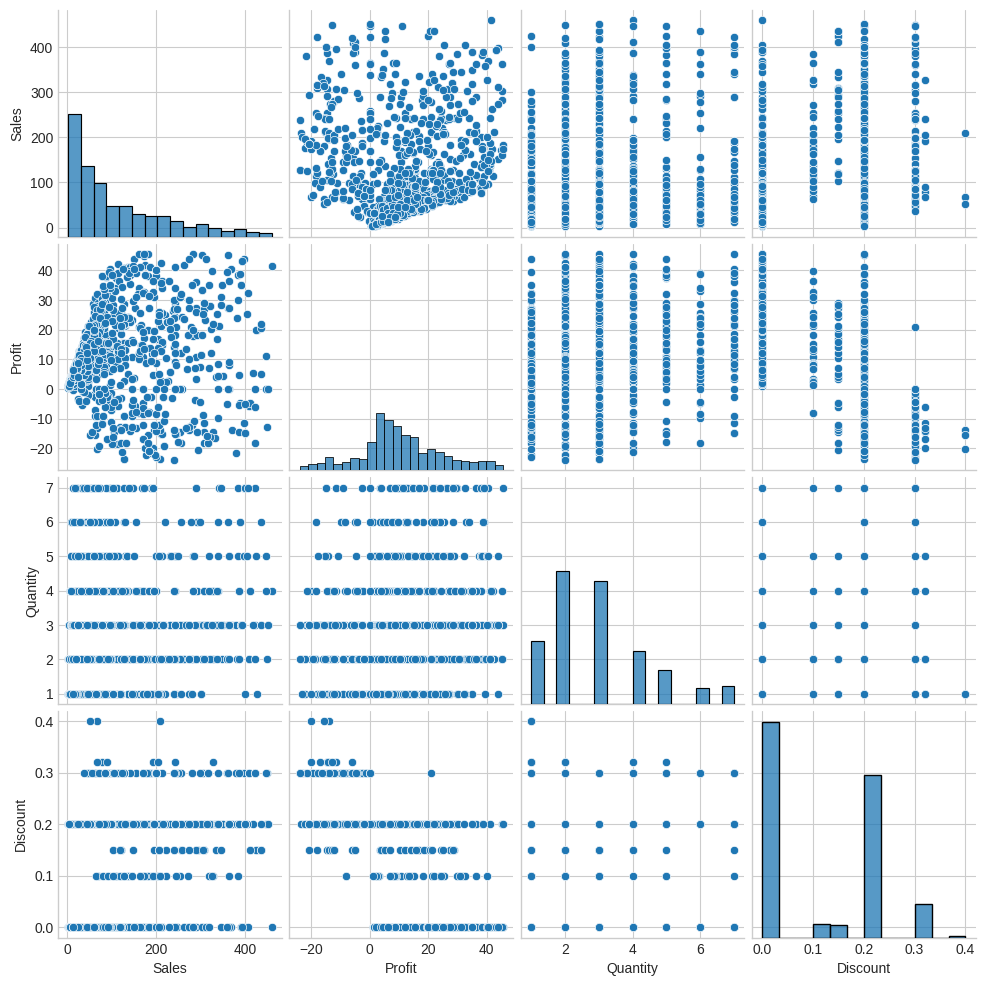

In [46]:
# Pair Plot for Numerical Features
sns.pairplot(df[['Sales', 'Profit', 'Quantity', 'Discount']])
plt.show()

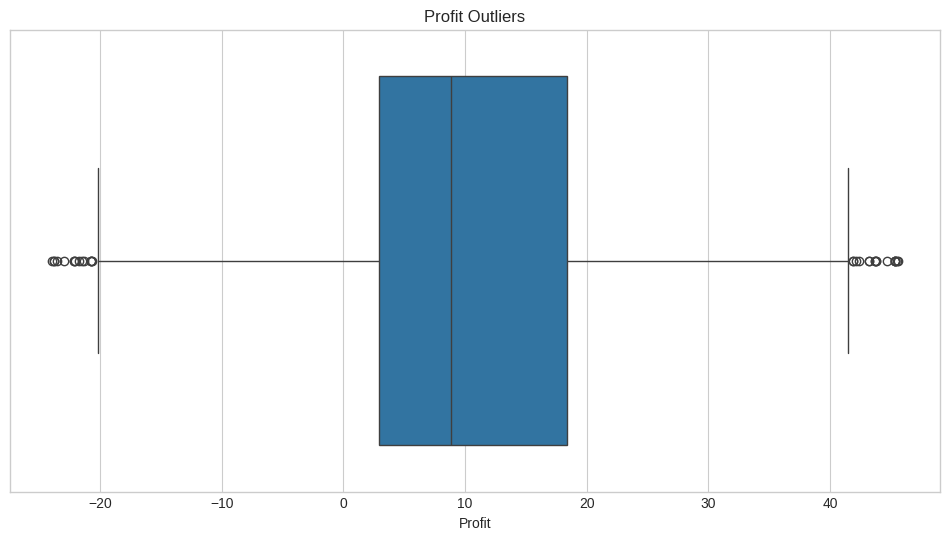

In [47]:
# Bokplot for outliers

### for profit column

plt.figure(figsize=(12, 6))
sns.boxplot(x=df['Profit'])
plt.title("Profit Outliers")
plt.show()

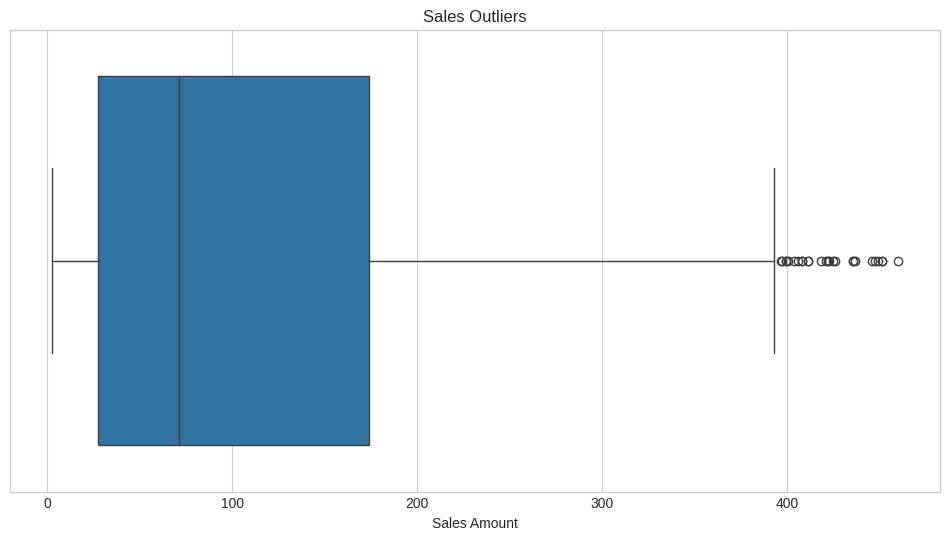

In [48]:
### for sales columns

plt.figure(figsize=(12, 6))
sns.boxplot(x=df['Sales'])
plt.title("Sales Outliers")
plt.xlabel("Sales Amount")
plt.show()

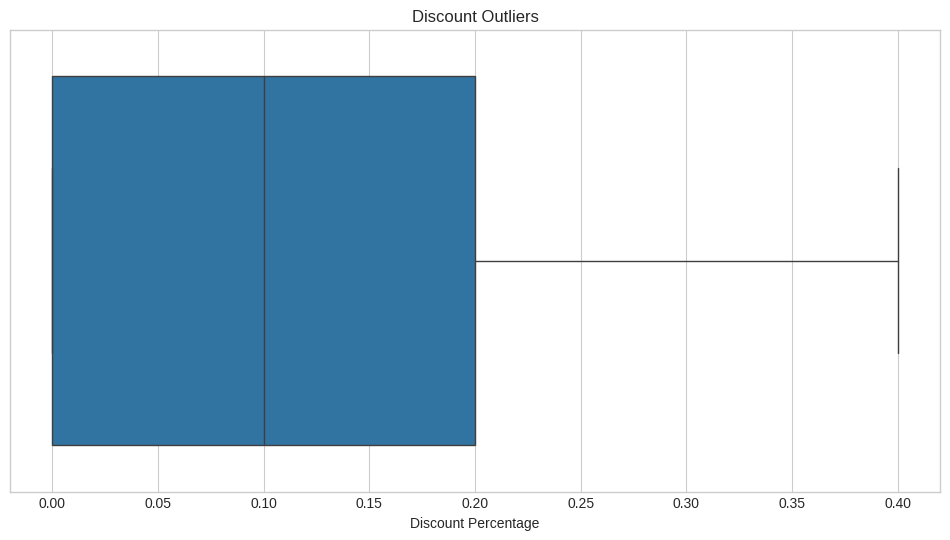

In [49]:
### for Discount columns

plt.figure(figsize=(12, 6))
sns.boxplot(x=df['Discount'])
plt.title("Discount Outliers")
plt.xlabel("Discount Percentage")
plt.show()

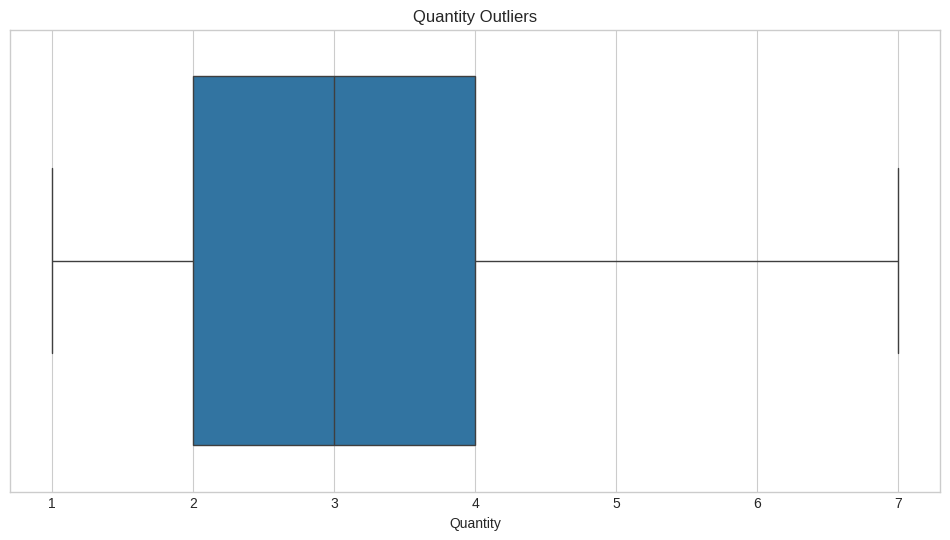

In [50]:
### for quantity columns

plt.figure(figsize=(12, 6))
sns.boxplot(x=df['Quantity'])
plt.title("Quantity Outliers")
plt.xlabel("Quantity")
plt.show()

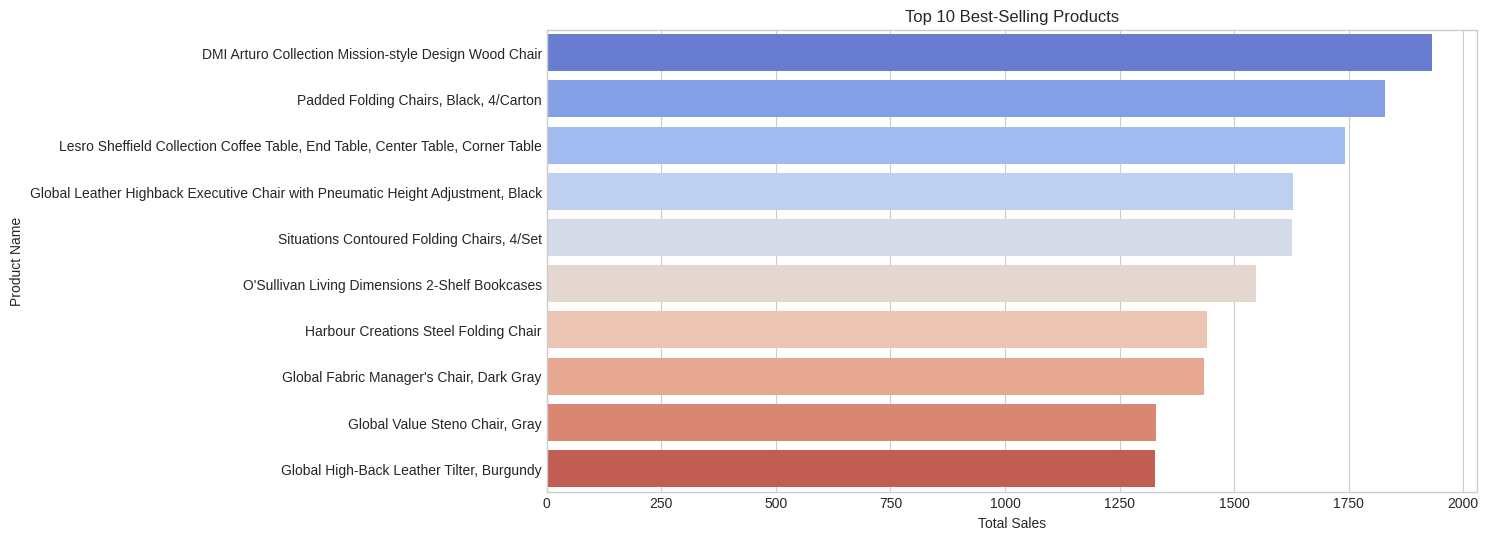

In [51]:
# products

## Top Selling Products
top_products = df.groupby("Product Name")["Sales"].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_products.values, y=top_products.index, palette='coolwarm')
plt.title("Top 10 Best-Selling Products")
plt.xlabel("Total Sales")
plt.ylabel("Product Name")
plt.show()

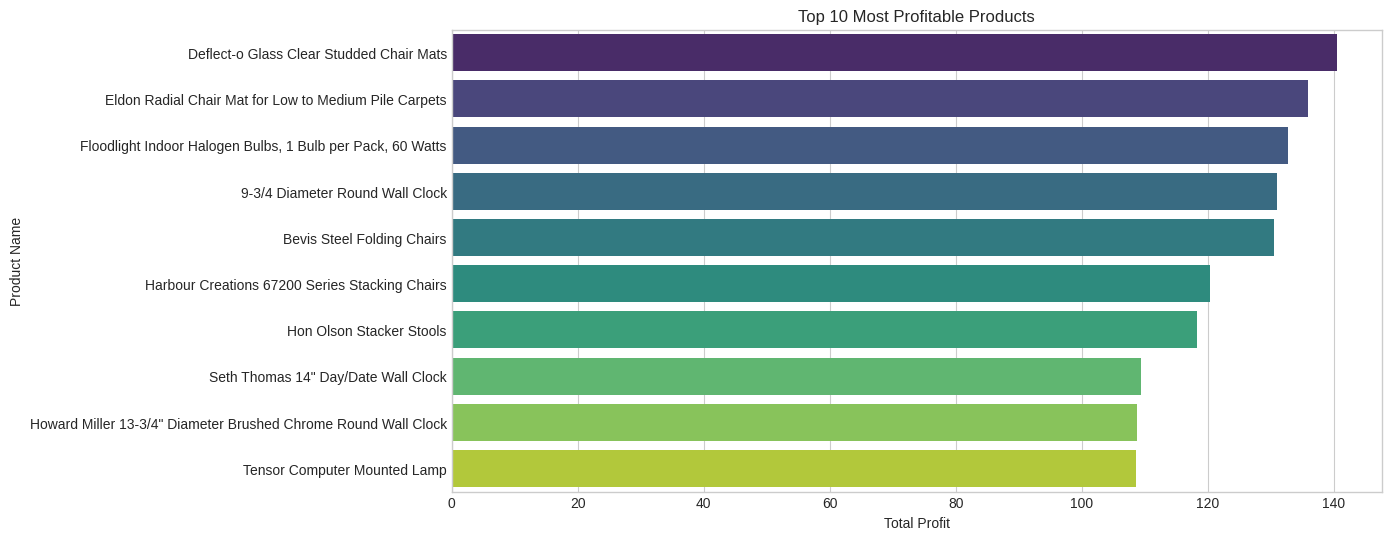

In [52]:
# Most Profitable Products
profitable_products = df.groupby("Product Name")["Profit"].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=profitable_products.values, y=profitable_products.index, palette='viridis')
plt.title("Top 10 Most Profitable Products")
plt.xlabel("Total Profit")
plt.ylabel("Product Name")
plt.show()

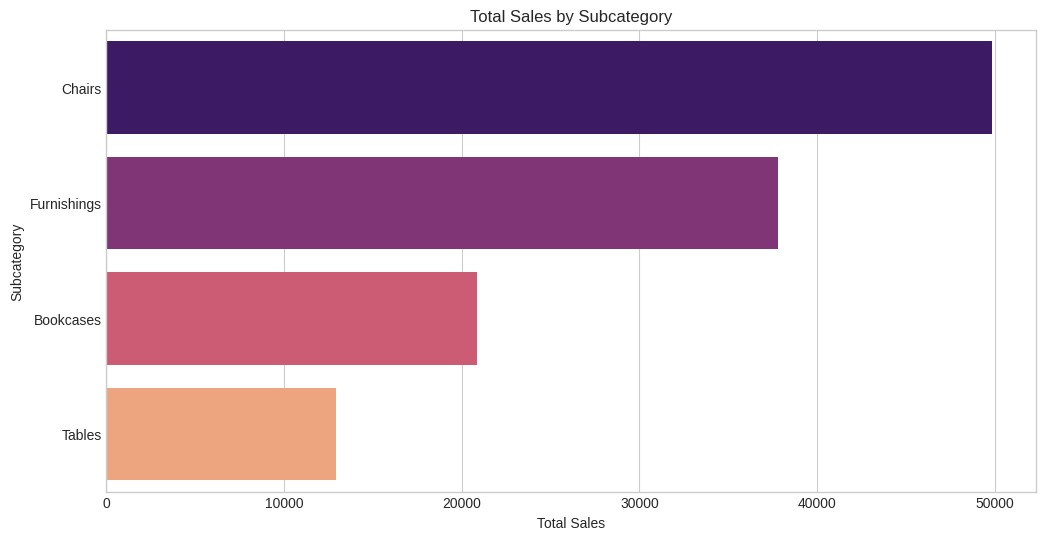

In [53]:
# Sales Analysis by Subcategory
subcategory_sales = df.groupby("Sub-Category")["Sales"].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=subcategory_sales.values, y=subcategory_sales.index, palette='magma')
plt.title("Total Sales by Subcategory")
plt.xlabel("Total Sales")
plt.ylabel("Subcategory")
plt.show()

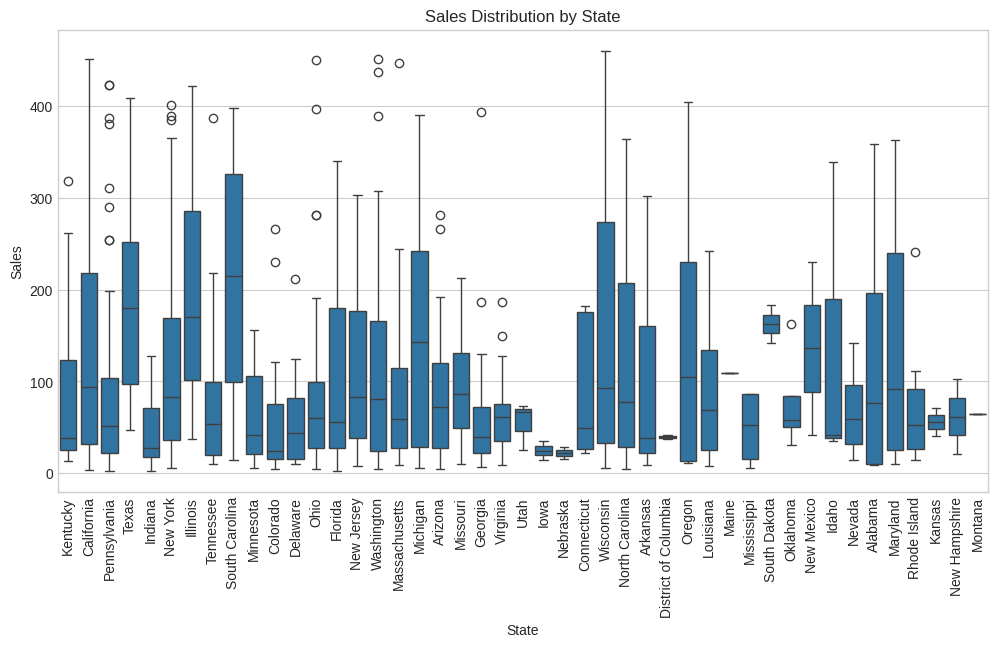

In [54]:
# sales distrubution by state
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['State'], y=df['Sales'])
plt.title("Sales Distribution by State")
plt.xlabel("State")
plt.ylabel("Sales")
plt.xticks(rotation=90)
plt.show()

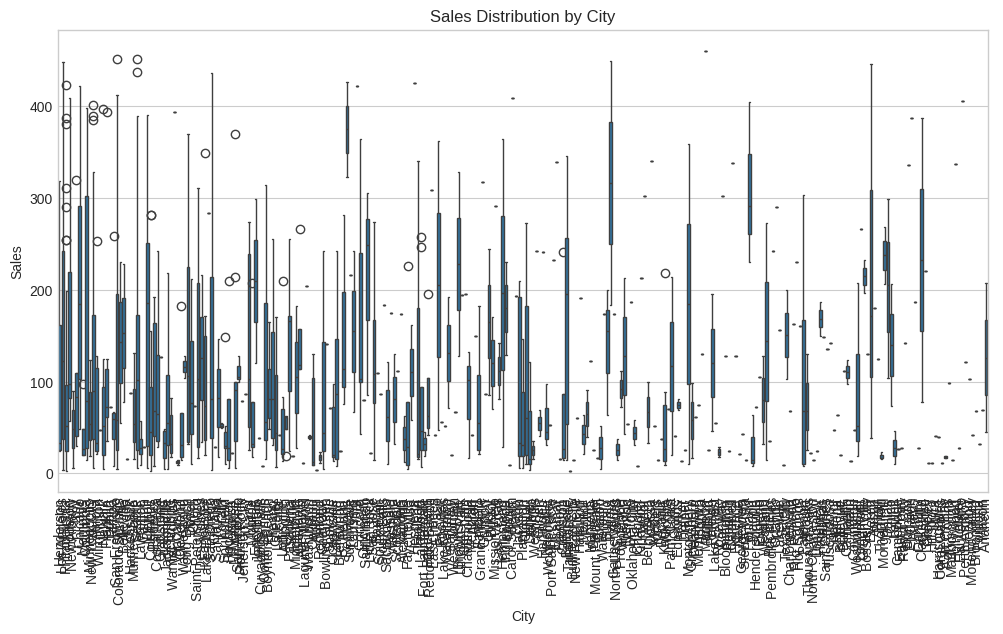

In [55]:
# Sales Distribution by City
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['City'], y=df['Sales'])
plt.title("Sales Distribution by City")
plt.xlabel("City")
plt.ylabel("Sales")
plt.xticks(rotation=90)
plt.show()

In [56]:
# 7. Test for stationarity on the log-transformed data
result = adfuller(monthly_sales['log_sales'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

is_stationary = result[1] <= 0.05

ADF Statistic: 0.12825219026222345
p-value: 0.9679379009860299
Critical Values:
	1%: -3.6209175221605827
	5%: -2.9435394610388332
	10%: -2.6104002410518627


In [57]:
# 8. Difference the series if not stationary
if not is_stationary:
    monthly_sales['log_diff'] = monthly_sales['log_sales'].diff().fillna(0)
    # Test stationarity of differenced series
    result_diff = adfuller(monthly_sales['log_diff'].dropna())
    print(f'ADF Statistic for Differenced Series: {result_diff[0]}')
    print(f'p-value: {result_diff[1]}')
    d_value = 1
else:
    monthly_sales['log_diff'] = monthly_sales['log_sales']
    d_value = 0

ADF Statistic for Differenced Series: -5.9545478133938845
p-value: 2.1083635462590683e-07


Training data: 38 months
Testing data: 10 months


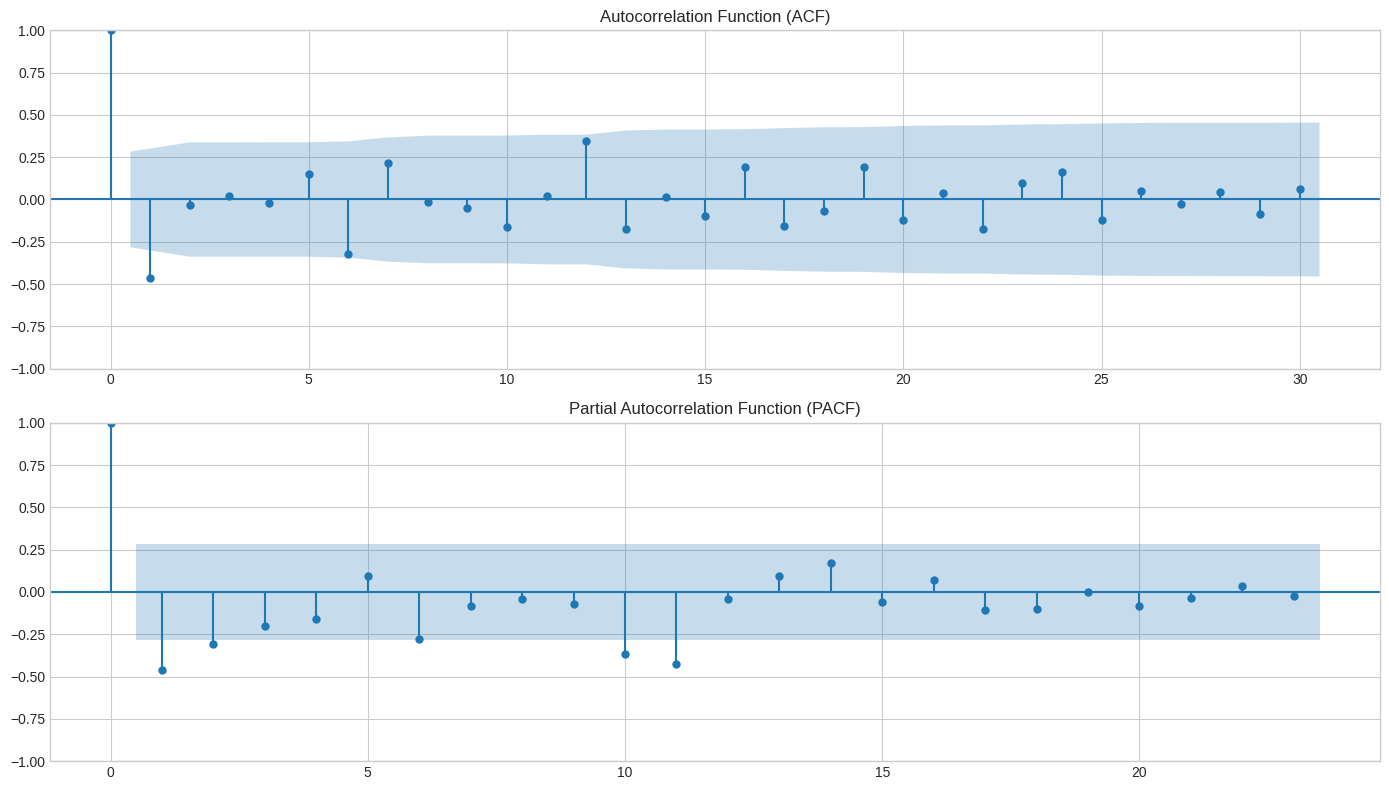

In [58]:
# 9. Plot ACF and PACF to determine AR and MA terms
plt.figure(figsize=(14, 8))

# ACF plot
plt.subplot(211)
plot_acf(monthly_sales['log_diff'].dropna(), ax=plt.gca(), lags=30)
plt.title('Autocorrelation Function (ACF)')

# PACF plot (reduce lags to be <= 50% of the sample size)
plt.subplot(212)
plot_pacf(monthly_sales['log_diff'].dropna(), ax=plt.gca(), lags=int(len(monthly_sales) * 0.5) - 1)
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()

# 10. Split the data into training and testing sets
train_size = int(len(monthly_sales) * 0.8)
train = monthly_sales.iloc[:train_size]
test = monthly_sales.iloc[train_size:]

print(f"Training data: {train.shape[0]} months")
print(f"Testing data: {test.shape[0]} months")


In [59]:
# 10. Split the data into training and testing sets
train_size = int(len(monthly_sales) * 0.8)
train = monthly_sales.iloc[:train_size]
test = monthly_sales.iloc[train_size:]

print(f"Training data: {train.shape[0]} months")
print(f"Testing data: {test.shape[0]} months")

Training data: 38 months
Testing data: 10 months


In [60]:
# 11. Fit SARIMA model
# Using seasonal parameters appropriate for monthly data
# p,d,q for non-seasonal component and P,D,Q,s for seasonal component
# s=12 for monthly seasonality
seasonal_order = (1, 1, 1, 12)  # Seasonal parameters (P,D,Q,s)

# Try multiple SARIMA models and choose the best one
best_aic = float('inf')
best_order = None
best_seasonal_order = None

# Define a grid of parameters to search
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)
P_values = range(0, 2)
D_values = range(0, 2)
Q_values = range(0, 2)

# Simplified grid search for demonstration (in practice, try more combinations)
for p in [0, 1, 2]:
    for q in [0, 1, 2]:
        for P in [0, 1]:
            for Q in [0, 1]:
                try:
                    order = (p, d_value, q)
                    seasonal_order = (P, 1, Q, 12)  # Fixed seasonal period of 12 months

                    model = SARIMAX(train['log_sales'],
                                   order=order,
                                   seasonal_order=seasonal_order,
                                   enforce_stationarity=False,
                                   enforce_invertibility=False)
                    results = model.fit(disp=False)

                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_order = order
                        best_seasonal_order = seasonal_order

                    print(f"SARIMA{order}x{seasonal_order} - AIC: {results.aic}")

                except Exception as e:
                    continue

print(f"Best SARIMA model: {best_order}x{best_seasonal_order} with AIC: {best_aic}")

# Fit the best model
final_model = SARIMAX(train['log_sales'],
                     order=best_order,
                     seasonal_order=best_seasonal_order,
                     enforce_stationarity=False,
                     enforce_invertibility=False)
final_results = final_model.fit(disp=False)
print(final_results.summary())


SARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC: 58.99161893981608
SARIMA(0, 1, 0)x(0, 1, 1, 12) - AIC: 26.970754373027795
SARIMA(0, 1, 0)x(1, 1, 0, 12) - AIC: 32.281015420087144
SARIMA(0, 1, 0)x(1, 1, 1, 12) - AIC: 28.16485746801746
SARIMA(0, 1, 1)x(0, 1, 0, 12) - AIC: 39.91612872187079
SARIMA(0, 1, 1)x(0, 1, 1, 12) - AIC: 18.111013966137033
SARIMA(0, 1, 1)x(1, 1, 0, 12) - AIC: 24.466325810193663
SARIMA(0, 1, 1)x(1, 1, 1, 12) - AIC: 23.086738615070097
SARIMA(0, 1, 2)x(0, 1, 0, 12) - AIC: 31.447139659165547
SARIMA(0, 1, 2)x(0, 1, 1, 12) - AIC: 16.374471679959306
SARIMA(0, 1, 2)x(1, 1, 0, 12) - AIC: 22.04788254177246
SARIMA(0, 1, 2)x(1, 1, 1, 12) - AIC: 16.8062675726679
SARIMA(1, 1, 0)x(0, 1, 0, 12) - AIC: 47.17538571319123
SARIMA(1, 1, 0)x(0, 1, 1, 12) - AIC: 27.83703381763389
SARIMA(1, 1, 0)x(1, 1, 0, 12) - AIC: 25.89497633445474
SARIMA(1, 1, 0)x(1, 1, 1, 12) - AIC: 25.47151101656327
SARIMA(1, 1, 1)x(0, 1, 0, 12) - AIC: 39.5098354211535
SARIMA(1, 1, 1)x(0, 1, 1, 12) - AIC: 17.260542088690954
SARI

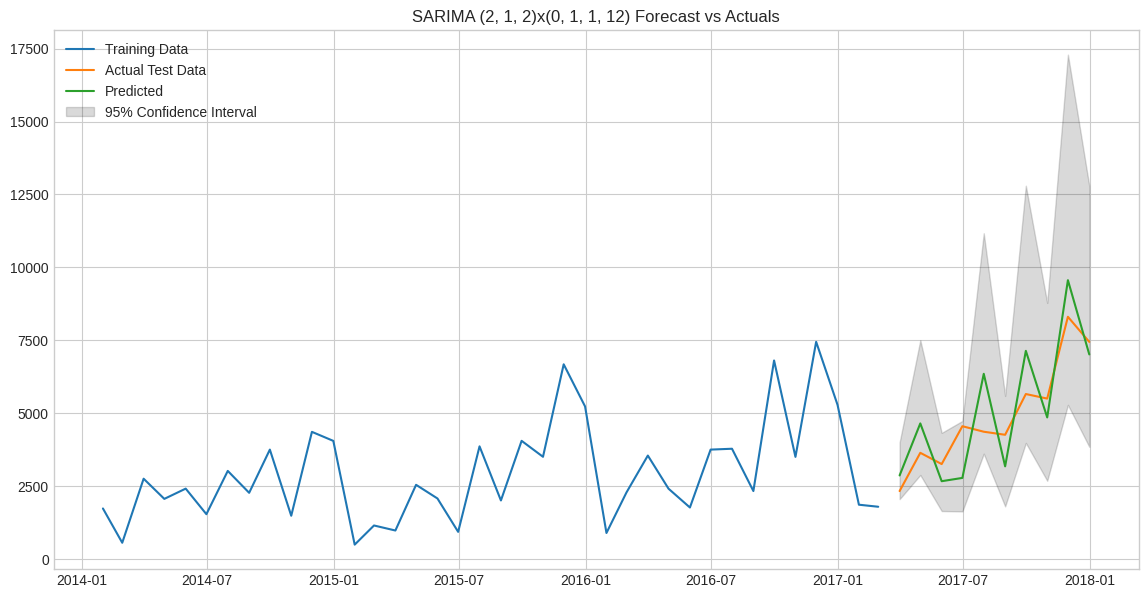

In [61]:
# 12. Make predictions on test data
pred_log = final_results.get_forecast(steps=len(test)).predicted_mean
pred_log_ci = final_results.get_forecast(steps=len(test)).conf_int()

# Convert predictions back from log scale
if 'offset' in locals():
    pred_mean = np.exp(pred_log) - offset
    pred_lower = np.exp(pred_log_ci.iloc[:, 0]) - offset
    pred_upper = np.exp(pred_log_ci.iloc[:, 1]) - offset
else:
    pred_mean = np.exp(pred_log)
    pred_lower = np.exp(pred_log_ci.iloc[:, 0])
    pred_upper = np.exp(pred_log_ci.iloc[:, 1])

# 13. Visualize predictions vs actuals
plt.figure(figsize=(14, 7))
plt.plot(train.index, train[sales_column], label='Training Data')
plt.plot(test.index, test[sales_column], label='Actual Test Data')
plt.plot(test.index, pred_mean, label='Predicted')
plt.fill_between(test.index,
                 pred_lower,
                 pred_upper,
                 color='k',
                 alpha=.15,
                 label='95% Confidence Interval')
plt.title(f'SARIMA {best_order}x{best_seasonal_order} Forecast vs Actuals')
plt.legend(loc='best')
plt.grid(True)

In [62]:
# 14. Calculate performance metrics
mse = mean_squared_error(test[sales_column], pred_mean)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test[sales_column], pred_mean)
r2 = r2_score(test[sales_column], pred_mean)

print("\nModel Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")

# Calculate MAPE if there are no zeros in the test data
if not np.any(test[sales_column] == 0):
    mape = np.mean(np.abs((test[sales_column] - pred_mean) / test[sales_column])) * 100
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Model Performance Metrics:
Mean Squared Error (MSE): 1427618.29
Root Mean Squared Error (RMSE): 1194.83
Mean Absolute Error (MAE): 1078.36
R² Score: 0.5350
Mean Absolute Percentage Error (MAPE): 23.73%


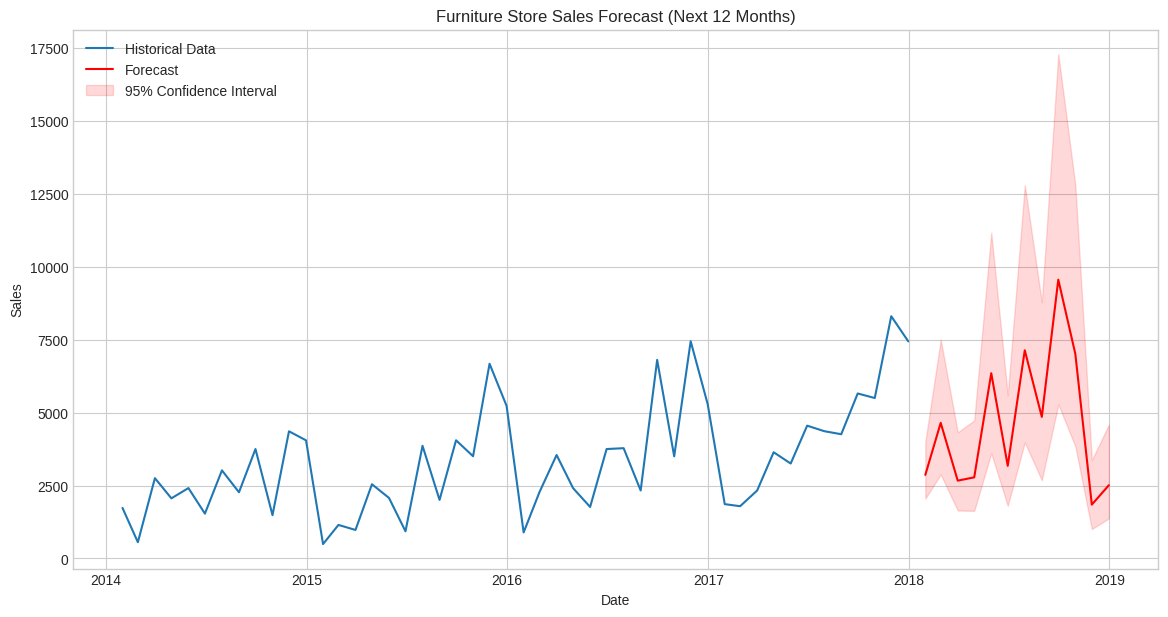

In [63]:
# 15. Forecast future periods
forecast_steps = 12  # One year ahead
forecast_log = final_results.get_forecast(steps=forecast_steps)
forecast_mean = forecast_log.predicted_mean
forecast_ci = forecast_log.conf_int()

# Convert forecast back from log scale
if 'offset' in locals():
    forecast_values = np.exp(forecast_mean) - offset
    forecast_lower = np.exp(forecast_ci.iloc[:, 0]) - offset
    forecast_upper = np.exp(forecast_ci.iloc[:, 1]) - offset
else:
    forecast_values = np.exp(forecast_mean)
    forecast_lower = np.exp(forecast_ci.iloc[:, 0])
    forecast_upper = np.exp(forecast_ci.iloc[:, 1])

# Create forecast dates
last_date = monthly_sales.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

# Plot historical data and forecast
plt.figure(figsize=(14, 7))
plt.plot(monthly_sales.index, monthly_sales[sales_column], label='Historical Data')
plt.plot(forecast_dates, forecast_values, color='red', label='Forecast')
plt.fill_between(forecast_dates,
                 forecast_lower,
                 forecast_upper,
                 color='red',
                 alpha=.15,
                 label='95% Confidence Interval')
plt.title(f'Furniture Store Sales Forecast (Next {forecast_steps} Months)')
plt.xlabel('Date')
plt.ylabel(sales_column)
plt.legend(loc='best')
plt.grid(True)

In [64]:
# 16. Business insights and recommendations
print("\nBusiness Insights and Recommendations:")
print("\n1. Sales Pattern Analysis:")
if np.mean(forecast_values) > np.mean(monthly_sales[sales_column][-12:]):
    print("   - Sales are projected to increase over the next year")
else:
    print("   - Sales are projected to remain stable or decrease over the next year")

# Identify peak months in forecast
forecast_df = pd.DataFrame({
    'Month': forecast_dates,
    'Forecast': forecast_values
})
peak_month = forecast_df.loc[forecast_df['Forecast'].idxmax(), 'Month'].strftime('%B %Y')
low_month = forecast_df.loc[forecast_df['Forecast'].idxmin(), 'Month'].strftime('%B %Y')

print(f"   - Peak sales projected in {peak_month}")
print(f"   - Lowest sales projected in {low_month}")

# Calculate growth rate
annual_growth = ((np.sum(forecast_values) / np.sum(monthly_sales[sales_column][-12:])) - 1) * 100
print(f"   - Projected annual growth rate: {annual_growth:.2f}%")

print("\n2. Inventory Management:")
print("   - Stock up inventory before projected peak sales months")
print("   - Consider reducing inventory during projected low sales months")
print("   - Maintain safety stock levels proportionate to forecast uncertainty")

print("\n3. Marketing and Promotions:")
print("   - Deploy promotional campaigns during forecasted low periods")
print("   - Capitalize on natural high seasons with premium pricing strategies")
print("   - Create targeted marketing campaigns for specific product categories")

print("\n4. Model Improvement Strategies:")
print("   - Incorporate external factors like holidays, economic indicators, and promotions")
print("   - Refine forecasting by segmenting analysis by product categories or regions")
print("   - Update forecast monthly with new sales data to improve accuracy")
print("   - Consider ensemble methods combining multiple forecasting approaches")


Business Insights and Recommendations:

1. Sales Pattern Analysis:
   - Sales are projected to increase over the next year
   - Peak sales projected in September 2018
   - Lowest sales projected in November 2018
   - Projected annual growth rate: 4.62%

2. Inventory Management:
   - Stock up inventory before projected peak sales months
   - Consider reducing inventory during projected low sales months
   - Maintain safety stock levels proportionate to forecast uncertainty

3. Marketing and Promotions:
   - Deploy promotional campaigns during forecasted low periods
   - Capitalize on natural high seasons with premium pricing strategies
   - Create targeted marketing campaigns for specific product categories

4. Model Improvement Strategies:
   - Incorporate external factors like holidays, economic indicators, and promotions
   - Refine forecasting by segmenting analysis by product categories or regions
   - Update forecast monthly with new sales data to improve accuracy
   - Consider e

In [69]:
# Generate predictions (in-sample or out-of-sample)
forecast = results.get_forecast(steps=30)  # adjust the number of steps as needed

# Extract the forecasted mean values
predicted_mean = forecast.predicted_mean

# Optionally, get confidence intervals
conf_int = forecast.conf_int()

# Combine into a DataFrame
df_forecast = pd.DataFrame({
    "Date": predicted_mean.index,
    "Forecasted_Sales": predicted_mean.values,
    "Lower_CI": conf_int.iloc[:, 0],
    "Upper_CI": conf_int.iloc[:, 1]
})

# Save to CSV
df_forecast.to_csv("sales_predictions.csv", index=False)


In [65]:
import joblib

joblib.dump(model, 'sales_forecasting_model.pkl')


['sales_forecasting_model.pkl']